In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
import nltk
nltk.download('averaged_perceptron_tagger')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, concatenate, Dense, Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
import tensorflow as tf


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\91983\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91983\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\91983\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\91983\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
dir_path="document1"
len(os.listdir(dir_path))

18828

In [3]:
label=[]
file=[] #getting labels and filenames
for i in os.listdir(dir_path):
    x,y=i.split("_")
    y=int(y.split('.')[0])
    label.append(x)
    file.append(y)

In [4]:
df=pd.DataFrame()
df["file"]=file
df["label"]=label
df.head(5)

,file,label
0,49960,alt.atheism
1,51060,alt.atheism
2,51119,alt.atheism
3,51120,alt.atheism
4,51121,alt.atheism


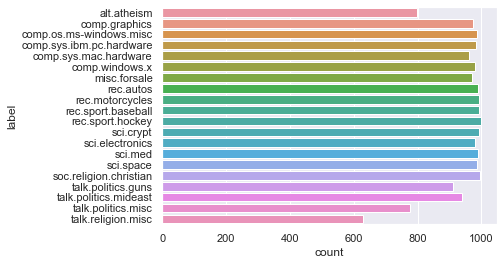

In [5]:
#count plot for labels
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(y="label", data=df)


In [6]:
label=[]
file=[]
from tqdm import tqdm
import glob
import re
preprocessed_emails=[]
preprocessed_text=[]
finaltext=[]
subject=[]
path='document1/*'
files=glob.glob(path)
def data_preprocessing(dir_path,files,c):
    count=0
    for i in os.listdir(dir_path):
        x,y=i.split("_")
        y=int(y.split('.')[0])
        label.append(x)
        file.append(y)
    for f in tqdm (files):
        with open(f,'r+') as fil: 
            for x in fil.readlines():
                
                if "Subject:" in x:
                    c+=1
                    if "Re:" in x :
                        y=x.split("Re:")
                        a=y[1].lower()
                        y = re.compile(r"\s+")

                        a = y.sub(" ", a).strip()
                        a=re.sub(r"[^a-zA-Z]"," ",a) #delete /,-,/n,/t
                        a = re.sub(r"\s+", ' ', a)
                        final_text= a
                        subject.append(a)
                        break
                    else:
                        y=x.split("Subject:")
                        s=y[1].lower()
                        i= re.compile(r"\s+")

                        s = i.sub(" ", s).strip()
                        s=re.sub(r"[^a-zA-Z]"," ",s) #delete /,-,/n,/t
                        s = re.sub(r"\s+", ' ', s)
                        final_text=s
                        subject.append(s)
                        break
        with open(f,'r+') as g:
            
            filedata=g.read()
            emails=re.findall(r"@[\w\.-]+\b", filedata)
            email_list=[]

            for i in emails:
                i=i.replace("@","")
            
                email_list.append(i)
            final_list=[]
            for i in email_list:
                split_email=i.split(".")
                for j in split_email:
                    if(len(j)<= 2 or j=="com"):
                        continue
                    else:
                        final_list.append(j)
            preprocessed_emails.append(" ".join(final_list))
            st=' '
            final_text+= st +" ".join(final_list)
        
        #replace_email=re.findall(r"@[a-z0-9\.\-+_]+\.[a-z]+",filedata)
        #for i in replace_email:
            #filedata=filedata.replace(i," ")
        
        
        f = re.sub(r'[\w\-\.]+@[\w\.-]+\b',' ',filedata)                      #replace email with space
        f = re.sub(r'Subject.*$'," ",f, flags=re.MULTILINE)            #replace subject with space
        f = re.sub(r"Write to:.*$","",f, flags=re.MULTILINE)           #replace write to with nothing 
        f = re.sub(r"From:.*$","",f, flags=re.MULTILINE)
        f = re.sub(r"or:","",f,flags=re.MULTILINE)

        f =re.sub("[\(\[].*?[\)\]]", "", f)#remoce brackets
        f = re.sub(r".*:","",f, flags=re.MULTILINE)                    #delete Anyword:
        
        f = re.sub(r"[\t\n\-\\\/]"," ",f) #delete /,-,/n,/t

        f = re.sub(r"won't", "will not", f)
        f = re.sub(r"can\'t", "can not", f)
        f = re.sub(r"n\'t", " not", f)
        f = re.sub(r"\'re", " are", f)
        f = re.sub(r"\'s", " is", f)
        f = re.sub(r"\'d", " would", f)
        f = re.sub(r"\'ll", " will", f)
        f = re.sub(r"\'t", " not", f)
        f = re.sub(r"\'ve", " have", f)
        f = re.sub(r"\'m", " am", f)
        chunking=[]
        chunking==list(ne_chunk(pos_tag(word_tokenize(f))))
        for c in chunking:
            if type(c)==Tree:
                if c.label()=="GPE":
                    k=c.leaves()
                    if len(k)>1:
                        gpe = "_".join([term for term,pos in k])

                        f = re.sub(rf'{k[1][0]}',gpe,f, flags=re.MULTILINE)  #replacing york with] new_york
                        f = re.sub(rf'\b{k[0][0]}\b',"",f, flags=re.MULTILINE) #deleting new,  \b is important

                if c.label()=="PERSON":                                         #removing person
                    for term,pog in c.leaves():
                        f = re.sub(re.escape(term),"",f, flags=re.MULTILINE)
                    

        f = re.sub(r'\d',"",f)
        f = re.sub(r"\b_([a-zA-z]+)_\b",r"\1",f)                                 #replace _word_ to word
        f = re.sub(r"\b_([a-zA-z]+)\b",r"\1",f)                                  #replace_word to word
        f = re.sub(r"\b([a-zA-z]+)_\b",r"\1",f)                                  #replace word_ to word
        f = re.sub(r"\b[a-zA-Z]{1}_([a-zA-Z]+)",r"\1",f)                         #d_berlin to berlin
        f = re.sub(r"\b[a-zA-Z]{2}_([a-zA-Z]+)",r"\1",f)                         #mr_cat to cat
        f = f.lower() 
        f = re.sub(r'\b\w{1,2}\b'," ",f)                                         #remove words <2
        f = re.sub(r"\b\w{15,}\b"," ",f)   
   
        f=re.sub(r"[^a-zA-Z_]"," ",f)
        f = re.sub(r" {2,}", " ", f)
        f= re.sub(r'\b\w{1,2}\b', '', f)
        # REMOVE THE EXTRA SPACES
        preprocessed_text.append(f)
        final_text+=f
        finaltext.append(final_text)
        
    return label,file,subject,preprocessed_text,preprocessed_emails,finaltext,c
        
        
label,file,subject,preprocessed_text,preprocessed_email,finaltext,c=data_preprocessing(dir_path,files,c=0)
        
          
                    

100%|████████████████████████████████████████████████████████████████████████████| 18828/18828 [32:31<00:00,  9.65it/s]


In [11]:
data=pd.DataFrame()
data["class"]=label
data['text']=preprocessed_text
data['email']=preprocessed_email
data['file']=file
data['subject']=subject
data["final_text"]=finaltext



In [12]:
label_encoder = preprocessing.LabelEncoder() 
data['class']=label_encoder.fit_transform(data['class'])
data['class']

0         0
1         0
2         0
3         0
4         0
         ..
18823    19
18824    19
18825    19
18826    19
18827    19
Name: class, Length: 18828, dtype: int32

In [13]:
X=data["final_text"]
Y=data["class"]
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.25, stratify=Y)

In [33]:
t = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')  #removing underscore from filters
t.fit_on_texts(x_train)
voc=len(t.word_index) +1
encode_train = t.texts_to_sequences(x_train)
encode_test = t.texts_to_sequences(x_test)


In [34]:
maxx=0
for i in encode_train:
    if len(i)>maxx:
        maxx = len(i)
maxx                              #this is now the length of each document in our corpus

8876

In [35]:
padded_text_train = pad_sequences(encode_train, maxlen=maxx, padding='post')
print(padded_text_train)

padded_text_test = pad_sequences(encode_test, maxlen=maxx, padding='post')
padded_text_test

[[  709  1951 26296 ...     0     0     0]
 [  965   797   297 ...     0     0     0]
 [ 2627  5076  2175 ...     0     0     0]
 ...
 [  518  9704   377 ...     0     0     0]
 [  399   398     5 ...     0     0     0]
 [ 5791  2739     5 ...     0     0     0]]


array([[  773,   214,  1403, ...,     0,     0,     0],
       [ 5442,  2600,    10, ...,     0,     0,     0],
       [ 4596,  1479,    26, ...,     0,     0,     0],
       ...,
       [ 1753,  2076, 53913, ...,     0,     0,     0],
       [11501,  2093,  1299, ...,     0,     0,     0],
       [  967,  4548, 41764, ...,     0,     0,     0]])

In [14]:
train_class = to_categorical(y_train)
train_class

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [15]:
test_class = to_categorical(y_test)
test_class

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [50]:
embeddings_index = dict()
glov = open('glove.6B.300d.txt.txt', encoding='utf8')
for line in glov:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
glov.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [51]:
embedding_matrix_train = np.zeros((voc, 300))
for word, i in t.word_index.items():
    embedding_vector_train = embeddings_index.get(word)
    if embedding_vector_train is not None:
        embedding_matrix_train[i] = embedding_vector_train

In [54]:

#embedding layer
embedd = Embedding(voc, 300, weights=[embedding_matrix_train], input_length=maxx, trainable=False)(i_layer)

#convolution 1D layer
conv1 = Coi_layer= Input(shape=(maxx,)) 
nv1D(16, kernel_size=9, activation='relu')(embedd)
conv2 = Conv1D(16, kernel_size=6, activation='relu')(embedd)
conv3 = Conv1D(16, kernel_size=3, activation='relu')(embedd)

#concatenate the convolution layers
concate1 = concatenate([conv1, conv2, conv3], axis=1)   #since axis 1 will have different values

#maxpool 1d layer
maxpool1 = MaxPooling1D(pool_size=4)(concate1)

#convlution layer 1D
conv4 = Conv1D(8, kernel_size=8, activation='relu')(maxpool1)
conv5 = Conv1D(8, kernel_size=4, activation='relu')(maxpool1)
conv6 = Conv1D(8, kernel_size=2, activation='relu')(maxpool1)

#concatenate the convolution layers
concate2 = concatenate([conv4,conv5, conv6], axis=1)

#maxpool 1d layer
maxpool2 = MaxPooling1D(pool_size=2)(concate2)

#convolution 1D layer
conv7 =  Conv1D(8, kernel_size=5, activation='relu')(maxpool2)

#flatten
flat = Flatten()(conv7)

#dropout
drop = Dropout(0.5)(flat)
#dense
dense = Dense(10, activation='relu')(drop)

#output layer
o_layer = Dense(20, activation='softmax')(dense)

#define the mode
model = Model(inputs=i_layer, outputs=o_layer)

#compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#summarize the model
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8876)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 8876, 300)    24923400    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 8868, 16)     43216       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 8871, 16)     28816       embedding[0][0]                  
______________________________________________________________________________________________

In [55]:
import datetime 
#tensorboard callback
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") #dirctory according to time
tfboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,write_graph=True)

#early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)

#modelcheckpoint callback to save the best model 
filepath = 'weights.{epoch:02d}-{val_loss:.2f}.hdf5'    #saves in the name of epoch and val_loss
chk_callback = tf.keras.callbacks.ModelCheckpoint(filepath,monitor='val_loss', mode='min',
                                                 save_best_only=True, save_weights_only=True)

In [60]:
model.fit(padded_text_train,train_class, epochs=10, validation_data=(padded_text_test,test_class), 
         callbacks=[tfboard_callback, es_callback, chk_callback])

Epoch 1/10
442/442 [==============================] - 1751s 4s/step - loss: 2.8508 - accuracy: 0.0982 - val_loss: 2.7258 - val_accuracy: 0.1130
Epoch 2/10
442/442 [==============================] - 1770s 4s/step - loss: 2.6648 - accuracy: 0.1197 - val_loss: 2.5517 - val_accuracy: 0.1470
Epoch 3/10
442/442 [==============================] - 1757s 4s/step - loss: 2.3368 - accuracy: 0.1753 - val_loss: 2.1658 - val_accuracy: 0.2428
Epoch 4/10
442/442 [==============================] - 1837s 4s/step - loss: 1.8909 - accuracy: 0.3213 - val_loss: 1.7520 - val_accuracy: 0.4105
Epoch 5/10
442/442 [==============================] - 1363s 3s/step - loss: 1.5520 - accuracy: 0.4473 - val_loss: 1.5003 - val_accuracy: 0.4631
Epoch 6/10
442/442 [==============================] - 1343s 3s/step - loss: 1.1823 - accuracy: 0.5481 - val_loss: 1.2834 - val_accuracy: 0.5581
Epoch 7/10
442/442 [==============================] - 1266s 3s/step - loss: 0.9258 - accuracy: 0.6370 - val_loss: 1.1504 - val_accuracy:

In [18]:
train_text=x_train.values
tk=Tokenizer(num_words=None,char_level=True,oov_token="UNK")
tk.fit_on_texts(texts)
test_text=x_test.values
train_texts = [s.lower() for s in train_text] 
test_texts = [s.lower() for s in test_text] 


In [28]:
vc=len(tk.word_index) +1
vc

30

In [20]:
alpha='abcdefghijklmnopqrstuvwxyz_-'
char_dict = {}
for i, char in enumerate(alpha):
    char_dict[char] = i + 1
    
# Use char_dict to replace the tk.word_index
tk.word_index = char_dict 
# Add 'UNK' to the vocabulary 
tk.word_index[tk.oov_token] = max(char_dict.values()) + 1

In [21]:
train_seq = tk.texts_to_sequences(train_texts)
test_seq = tk.texts_to_sequences(test_texts)
train_data = pad_sequences(train_seq, maxlen=8876, padding='post')
test_data = pad_sequences(test_seq, maxlen=8876, padding='post')
train_data = np.array(train_data)
test_data = np.array(test_data)


In [22]:
train_data.shape

(14121, 8876)

In [23]:
test_data.shape

(4707, 8876)

In [31]:
i_layer= Input(shape=(8876,))
emb=Embedding(vc,20,input_length=8876,mask_zero=True)(i_layer)
conv1 = Conv1D(16, kernel_size=9, activation='relu')(emb)
conv2 = Conv1D(16, kernel_size=6, activation='relu')(conv1)
maxpool1 = MaxPooling1D(pool_size=4)(conv2)
conv3 = Conv1D(8, kernel_size=2, activation='relu')(maxpool1)
conv4 =  Conv1D(8, kernel_size=5, activation='relu')(conv3)
maxpool1 = MaxPooling1D(pool_size=2)(conv4)
flat = Flatten()(maxpool1)
drop = Dropout(0.5)(flat)

dense = Dense(10, activation='relu')(drop)
o_layer = Dense(20, activation='softmax')(dense)
model = Model(inputs=i_layer, outputs=o_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())





Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 8876)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 8876, 20)          600       
_________________________________________________________________
conv1d (Conv1D)              (None, 8868, 16)          2896      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8863, 16)          1552      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2215, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2214, 8)           264       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2210, 8)           328   

In [32]:
import datetime 
#tensorboard callback
log_dir="/content/drive/My Drive/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") #dirctory according to time
tfboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,write_graph=True)

#early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)

#modelcheckpoint callback to save the best model 
filepath = '/content/drive/My Drive/weights.{epoch:02d}-{val_loss:.2f}.hdf5'    #saves in the name of epoch and val_loss
chk_callback = tf.keras.callbacks.ModelCheckpoint(filepath,monitor='val_loss', mode='min',
                                                 save_best_only=True, save_weights_only=True)

In [33]:
model.fit(train_data,train_class, epochs=30, validation_data=(test_data,test_class), 
         callbacks=[tfboard_callback, es_callback, chk_callback])

Epoch 1/30
442/442 [==============================] - 122s 276ms/step - loss: 2.9614 - accuracy: 0.0724 - val_loss: 2.9126 - val_accuracy: 0.0907
Epoch 2/30
442/442 [==============================] - 123s 278ms/step - loss: 2.8070 - accuracy: 0.1067 - val_loss: 2.6843 - val_accuracy: 0.1266
Epoch 3/30
442/442 [==============================] - 132s 298ms/step - loss: 2.6077 - accuracy: 0.1366 - val_loss: 2.5348 - val_accuracy: 0.1528
Epoch 4/30
442/442 [==============================] - 126s 285ms/step - loss: 2.5051 - accuracy: 0.1575 - val_loss: 2.5232 - val_accuracy: 0.1464
Epoch 5/30
442/442 [==============================] - 119s 269ms/step - loss: 2.4289 - accuracy: 0.1722 - val_loss: 2.4195 - val_accuracy: 0.1793
Epoch 6/30
442/442 [==============================] - 120s 272ms/step - loss: 2.3690 - accuracy: 0.1854 - val_loss: 2.5112 - val_accuracy: 0.1646
Epoch 7/30
442/442 [==============================] - 123s 277ms/step - loss: 2.3277 - accuracy: 0.1999 - val_loss: 2.4293 -

KeyboardInterrupt: 